## Import modules and data

In [2]:
import pandas as pd
import hddm

data = hddm.load_csv('risk_data.csv')

/anaconda3/lib/python2.7/site-packages/IPython/parallel.py:13: ShimWarning: The `IPython.parallel` package has been deprecated since IPython 4.0. You should import from ipyparallel instead.
  "You should import from ipyparallel instead.", ShimWarning)


## Regression model

In [3]:
m = hddm.models.HDDMRegressor(data, ['v ~ gain + loss', 'a ~ loss'], include=('z'), group_only_regressors=False)

Adding these covariates:
['v_Intercept', 'v_gain', 'v_loss']
Adding these covariates:
['a_Intercept', 'a_loss']


In [4]:
m.find_starting_values()

/anaconda3/lib/python2.7/site-packages/scipy/optimize/optimize.py:1934: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/anaconda3/lib/python2.7/site-packages/scipy/optimize/optimize.py:1935: RuntimeWarning: invalid value encountered in double_scalars
  p = (x - v) * tmp2 - (x - w) * tmp1


In [5]:
m.sample(2500, burn=1000)

 [-----------------100%-----------------] 2501 of 2500 complete in 35793.7 sec

## Results

In [10]:
import numpy as np
numSubjects = 49
df = m.nodes_db

print(m.nodes_db)

lambdas = []
for subjectIndex in range(1, numSubjects+1):
    beta_gain = df.loc['v_gain_subj.{}'.format(subjectIndex), 'mean']
    beta_loss = df.loc['v_loss_subj.{}'.format(subjectIndex), 'mean']
    lambdas.append(beta_loss/beta_gain)
    
Lambda = np.mean(lambdas)
print("Mean value of lambda = ", Lambda)

          knode_name stochastic observed   subj       node tag     depends  \
t                  t       True    False  False          t  ()          []   
t_std          t_std       True    False  False      t_std  ()          []   
t_rate        t_rate      False    False  False     t_rate  ()          []   
t_shape      t_shape      False    False  False    t_shape  ()          []   
t_subj.1      t_subj       True    False   True   t_subj.1  ()  [subj_idx]   
t_subj.2      t_subj       True    False   True   t_subj.2  ()  [subj_idx]   
t_subj.3      t_subj       True    False   True   t_subj.3  ()  [subj_idx]   
t_subj.4      t_subj       True    False   True   t_subj.4  ()  [subj_idx]   
t_subj.5      t_subj       True    False   True   t_subj.5  ()  [subj_idx]   
t_subj.6      t_subj       True    False   True   t_subj.6  ()  [subj_idx]   
t_subj.7      t_subj       True    False   True   t_subj.7  ()  [subj_idx]   
t_subj.8      t_subj       True    False   True   t_subj.8  ()  

In [23]:
# a = a_intercept + a_loss x loss
# loss = 10, 20, 30, 40, 50, 60, 70, 80, 90, 100
import numpy as np
allLosses = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
def a_mean_participant(a_intercept, a_loss):
    all_a = []
    for loss in allLosses:
        a = a_intercept + a_loss*loss
        all_a.append(a)
    
    mean_a = np.mean(all_a)
    return mean_a 

db = m.nodes_db
def getACovariatesForParticipant(participantIndex):
    a_intercept = db.loc['a_Intercept_subj.{}'.format(participantIndex), 'mean']
    a_loss = db.loc['a_loss_subj.{}'.format(participantIndex), 'mean']
    
    return a_intercept, a_loss

numParticipants = 49
allA = []
for participantIndex in range(1, numParticipants+1):
    participant_a = a_mean_participant(*getACovariatesForParticipant(participantIndex))
    allA.append(participant_a)
    
print("Mean value of a: ", np.mean(allA))

('Mean value of a: ', 1.670978170932195)


In [1]:
# mean value of the bias
allZ = []
for participantIndex in range(1, numParticipants+1):
    z_participant = db.loc['z_subj.{}'.format(participantIndex), 'mean']
    z_adjusted = (z_participant - 0.5)*allA[participantIndex-1]
    allZ.append(z_adjusted)
    
mean_Z = np.mean(allZ)
print("Mean value of Bias: ", mean_Z)

NameError: name 'numParticipants' is not defined

## Plots

Text(0,0.5,'Coefficient for Loss')

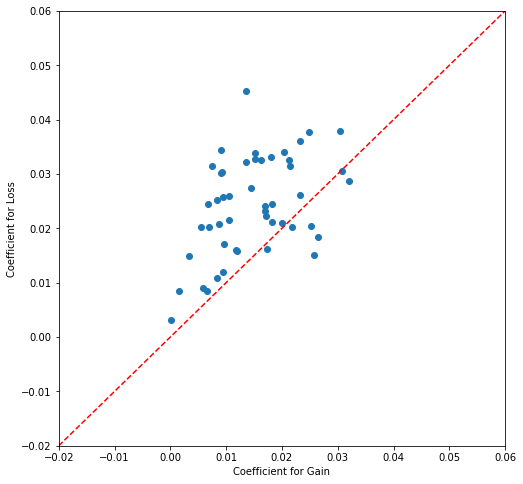

In [62]:
from matplotlib import pyplot as plt
import numpy as np

all_beta_gain = []
all_beta_loss = []

for subjectIndex in range(1, numSubjects+1):
    all_beta_gain.append(df.loc['v_gain_subj.{}'.format(subjectIndex), 'mean'])
    all_beta_loss.append(df.loc['v_loss_subj.{}'.format(subjectIndex), 'mean'])

fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(all_beta_gain, all_beta_loss)

line_x = (-0.02, 0.06)
line_y = (-0.02, 0.06)
ax.plot(line_x, line_y, 'r--')

ax.set_xlim(-0.02, 0.06)
ax.set_ylim(-0.02, 0.06)
ax.set_xlabel("Coefficient for Gain")
ax.set_ylabel("Coefficient for Loss")

Text(0,0.5,'Predecisional Bias')

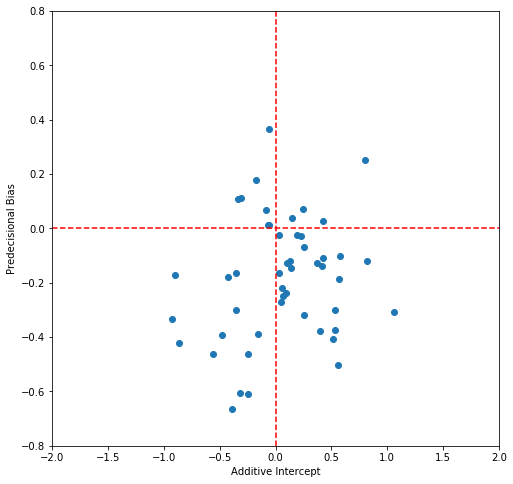

In [67]:
all_alpha = []
for participantIndex in range(1, numParticipants+1):
    all_alpha.append(db.loc['v_Intercept_subj.{}'.format(participantIndex), 'mean'])
    
fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(all_alpha, allZ)
horizontalLineX = (-2, +2)
horizontalLineY = (0, 0)
verticalLineX = (0, 0)
verticalLineY = (-0.8, 0.8)
ax.plot(horizontalLineX, horizontalLineY, 'r--')
ax.plot(verticalLineX, verticalLineY, 'r--')

ax.set_xlim(-2, 2)
ax.set_ylim(-0.8, 0.8)
ax.set_xlabel("Additive Intercept")
ax.set_ylabel("Predecisional Bias")

In [72]:
# compute P(Accept)
grouped = data.groupby("subj_idx")
all_p_accept = grouped["response"].aggregate(np.mean).to_list()

Text(0,0.5,'P(Acceptance)')

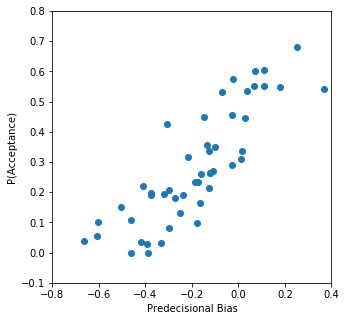

In [78]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter(allZ, all_p_accept)
ax.set_xlim(-0.8, 0.4)
ax.set_ylim(-0.1, 0.8)
ax.set_xlabel("Predecisional Bias")
ax.set_ylabel("P(Acceptance)")

In [81]:
from scipy.stats.stats import pearsonr
print("Pearson Correlation between Predecisional Bias and P(Acceptance) is: ", pearsonr(all_p_accept, allZ))

('Pearson Correlation between Predecisional Bias and P(Acceptance) is: ', (0.8463611104279926, 1.8784482987442613e-14))


Text(0,0.5,'P(Acceptance)')

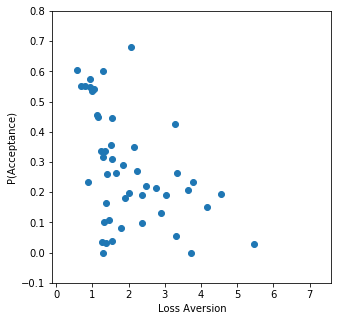

In [80]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter(lambdas, all_p_accept)
ax.set_xlim(-0.1, 7.6)
ax.set_ylim(-0.1, 0.8)
ax.set_xlabel("Loss Aversion")
ax.set_ylabel("P(Acceptance)")

In [85]:
print("Pearson Correlation between Loss Aversion and P(Acceptance) is: ", pearsonr(all_p_accept, lambdas))

('Pearson Correlation between Loss Aversion and P(Acceptance) is: ', (0.08936536896460241, 0.5414429857303582))


In [87]:
m.print_stats()

                            mean          std         2.5q          25q          50q          75q        97.5q       mc err
t                       0.422386    0.0167411     0.389825     0.411288      0.42207     0.433943     0.454532  0.000563008
t_std                     0.1115    0.0132146    0.0886482     0.102136     0.110593     0.119404     0.140056  0.000440808
t_subj.1                0.407297    0.0301767     0.341207     0.387037     0.409806     0.430233     0.459448   0.00127882
t_subj.2                0.456666    0.0115256     0.428722     0.450879      0.45833     0.464602     0.474076  0.000456461
t_subj.3                 0.36231     0.031095      0.28994     0.343515     0.364787     0.383612     0.416238   0.00156362
t_subj.4                0.613783    0.0182105     0.574591      0.60145      0.61484     0.626715     0.645112  0.000725847
t_subj.5                0.355707    0.0164925     0.317767     0.346002     0.357647     0.368172     0.381566   0.00101091
t_subj.6

# Choice Probability vs. choice-factor adjusted RT